In [9]:
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
# reading the dataset 

df = pd.read_json('mt_for_eval.json', orient='records')
df.head()

,field,title,en_text,ru_human_translation,prompt,ru_machine_translation
0,literature,Of Human Bondage by Somerset Maugham,"[The day broke gray and dull., The clouds hung...","[День занялся тусклый, серый., Тучи повисли ни...",You are an expert translator. Translate the fo...,"[День начался серым и унылым., Облака висели г..."
1,literature,A Tale of Two Cities by Charles Dickens,"[It was the best of times, it was the worst of...","[ Это было лучшее из всех времен, это было худ...",You are an expert translator. Translate the fo...,"[Это было лучшее время, это было худшее время,..."
2,medical,Barnard C.N. The operation. A human cardiac tr...,"[POSTOPERATIVE CARE., The postoperative care o...","[Послеоперационное ведение., Послеоперационное...",You are an expert translator. Translate the fo...,"[ПОСЛЕОПЕРАЦИОННЫЙ УХОД., Послеоперационный ух..."
3,medical,"Guidelines on diabetes, pre-diabetes, and card...","[Definition and classification of diabetes., C...","[Определение и классификация диабета., Критери...",You are an expert translator. Translate the fo...,"[Определение и классификация диабета., Критери..."
4,law,CODE OF CONDUCT FOR EUROPEAN LAWYERS,"[1., PREAMBLE., 1.1., The Function of the Lawy...","[I. Преамбула., 1.1., Функция адвоката в общес...",You are an expert translator. Translate the fo...,"[1., ПРЕАМБУЛА., 1.1., Функция адвоката в обще..."


In [58]:
# adding prompt names to the dataframe and printing the prompts used for translation

unique_prompts = df['prompt'].unique()
prompt_name_mapping = {prompt: f'Prompt {i+1}' for i, prompt in enumerate(unique_prompts)}
df['prompt_name'] = df['prompt'].map(prompt_name_mapping)
display(prompt_name_mapping)

{'You are an expert translator. Translate the following text to Russian. The text to be translated is:': 'Prompt 1',
 'You are an expert translator that will be tasked with translating a piece of text into Russian. The translation must be faithful to the original tone of voice and writing style. Ensure that the meaning of the original text is not changed. The text to be translated is:': 'Prompt 2'}

In [59]:
# merging together texts in the same field and used with the same prompts

def merge_sentences(text_list):
    return sum(text_list, [])

columns_to_merge = ['en_text', 'ru_human_translation', 'ru_machine_translation']

df_merged = df.groupby(['field', 'prompt_name']).agg({
    col: merge_sentences for col in columns_to_merge}).reset_index()

### BLEU

The BLEU (Bilingual Evaluation Understudy) metric calculates its score by looking at the overlap between the words and phrases in the machine-translated text and the reference translation. It counts the number of matching words and gives higher weight to longer matches. Then, it calculates a precision score based on these matches. Finally, it combines these precision scores to give an overall BLEU score, which indicates how well the machine translation matches the reference translation.\
\
\
https://huggingface.co/spaces/evaluate-metric/bleu \
https://www.baeldung.com/cs/nlp-bleu-score

In [40]:
bleu = evaluate.load("bleu")

In [62]:
# calculating BLEU

df_bleu = df_merged.copy()

df_bleu['bleu'] = df_bleu.apply(
    lambda x: bleu.compute(predictions=x.ru_machine_translation, references=x.ru_human_translation)['bleu'], 
    axis=1)

df_bleu.drop(columns_to_merge, axis=1, inplace=True)

In [63]:
df_bleu

,field,prompt_name,bleu
0,law,Prompt 1,0.097152
1,law,Prompt 2,0.101142
2,literature,Prompt 1,0.121238
3,literature,Prompt 2,0.104455
4,medical,Prompt 1,0.037916
5,medical,Prompt 2,0.033303


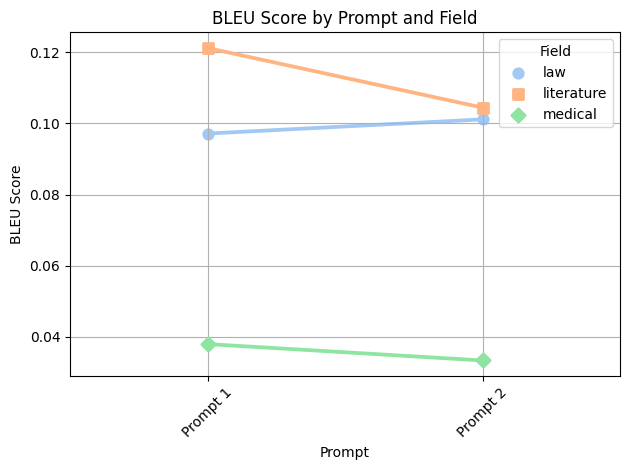

In [64]:
# plotting the results

sns.pointplot(data=df_bleu, x='prompt_name', y='bleu', hue='field', dodge=False, markers=["o", "s", "D"], palette='pastel')
plt.title('BLEU Score by Prompt and Field')
plt.xlabel('Prompt')
plt.ylabel('BLEU Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Field')
plt.grid(True)  # Add grid
plt.show()

### COMET

COMET (Crosslingual Optimized Metric for Evaluation of Translation) is a metric for automatic evaluation of machine translation that calculates the similarity between a machine translation output and a reference translation using token or sentence embeddings.
It is based on similarity of vector representations. \
A score close to 1 indicates a high-quality translation, while a score close to 0 indicates a translation that is no better than random chance.
\
\
https://github.com/Unbabel/COMET

In [65]:
from comet import download_model, load_from_checkpoint

model_path = download_model("Unbabel/wmt22-comet-da")  # default COMET model

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [66]:
# Load the model checkpoint:
model = load_from_checkpoint(model_path)

Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.2.1. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint C:\Users\svvlk\.cache\huggingface\hub\models--Unbabel--wmt22-comet-da\snapshots\371e9839ca4e213dde891b066cf3080f75ec7e72\checkpoints\model.ckpt`
Encoder model frozen.
c:\Users\svvlk\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\core\saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [67]:
# creating functions to convert the data into the format accepted by the COMET model
# and calculate COMET scores

def calculate_comet(data):
    return model.predict(data, batch_size=8, gpus=0)

def construct_data_for_prediction(row):
    return [{"src": row['en_text'], "mt": row['ru_machine_translation'], "ref": row['ru_human_translation']}]

df_comet = df_merged.copy()

df_comet['comet'] = df_comet.apply(
    lambda row: calculate_comet(construct_data_for_prediction(row))['system_score'], axis=1
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 1/1 [00:05<00:00,  5.71s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 1/1 [00:05<00:00,  5.71s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 1/1 [00:05<00:00,  5.62s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Predicting DataLoader 0: 100%|██████████| 1/1 [00:05<00:00,  5.67s/it]
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: Fa

In [68]:
# viewing COMET scores

df_comet.drop(columns_to_merge, axis=1, inplace=True)
df_comet

,field,prompt_name,comet
0,law,Prompt 1,0.925644
1,law,Prompt 2,0.930009
2,literature,Prompt 1,0.896352
3,literature,Prompt 2,0.890450
4,medical,Prompt 1,0.870131
5,medical,Prompt 2,0.875312


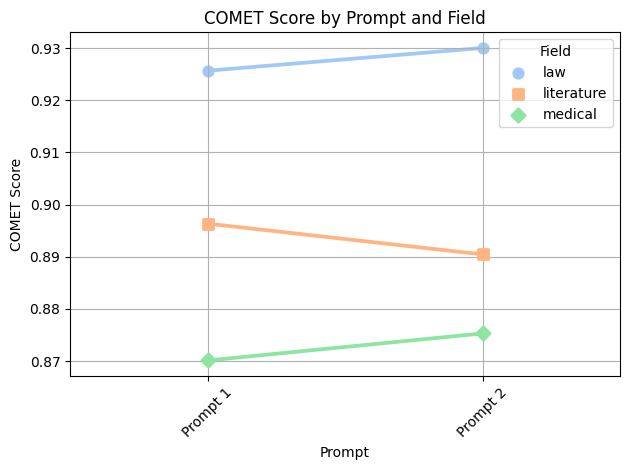

In [69]:
# plotting the results

sns.pointplot(data=df_comet, x='prompt_name', y='comet', hue='field', dodge=False, markers=["o", "s", "D"], palette='pastel')
plt.title('COMET Score by Prompt and Field')
plt.xlabel('Prompt')
plt.ylabel('COMET Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Field')
plt.grid(True)  # Add grid
plt.show()

From the provided BLEU and COMET scores for different prompts and text genres, we can draw several conclusions:

1. Comparison of Prompt Performance:

* The results show overall little difference between the prompts, however, both metrics indicated that Promt 2 worked a little better with legal texts, while Prompt 1 yielded better literary translations. Perhaps, prompts tailored for each field specifically could improve the scores.

2. Text Genre Comparison:

* Legal texts exhibit higher scores on both BLEU and COMET metrics. This can be attributed to the presence of specialized terminology and structured language typical in legal documents. The use of precise legal terminology might result in high word and phrase overlap (as measured by BLEU), while maintaining semantic similarity (as captured by COMET).

* Literature translations received high scores on BLEU but lower scores on COMET, which is unexpected, but perhaps can be attributed to the selection of the text data. Literary translations typically involve various interpretations and don't necessarily align closely with the reference. The lower COMET score might stem from the complexity of literary texts, resulting in lower semantic similarity scores.

* Medical texts scored lower on both COMET and BLEU. This pattern can be explained by the presence of highly specialized terminology in medical documents, resulting in higher divergence in both word overlap and semantic similarity.

Overall Model Performance:

The GPT-3.5-Turbo model demonstrates better performance in terms of semantic similarity (as measured by COMET) compared to word overlap (as measured by BLEU). This suggests that while the literal word overlap might vary, the overall meaning and semantic content of the translations are well-preserved.

It would be beneficial to analyze specific examples where the model performs well/poorly to understand the strengths and weaknesses of the translations produced by each prompt and for each text genre.
Fine-tuning the prompts, collecting a larger dataset, or exploring other techniques to improve translation quality, especially for challenging text genres like literature and medical texts, could be considered.